# Vistelius data digitalization

In [3]:
# Package used to work with OCR tables
import tabula

# Linear algebra package
import numpy as np

# Tabular data package
import pandas as pd
from pandas.api.types import is_numeric_dtype, is_string_dtype

# Operating system package
import os

# Parallellization modules and packages
from joblib import Parallel, delayed
import multiprocessing

# Regular expressions package
import re

In [4]:
# TEST CASE of regex

line = "81 - (60°46' ,153°20'). Granite alkalline. K2. Sukhoy massif. G.I.Finogentova. Det .: H2o+-0.43 (Yu.G.Kobylyansky,1964)."

line = re.sub(r"·", "", line)
line = re.sub(r"•", "", line)
line = re.sub(r"([^A-z0-9])(\s+)([A-z0-9]{2,})", r'|\0\1\3', line)
line = re.sub(r"([A-z0-9]){2,}(\s+)([^A-z0-9])", r'\0\1|\3', line)
line.replace("\x00", "")

"1|- (60°46' ,153°20')|.Granite alkalline|.K2|.Sukhoy massif. G.I.Finogentova|.t|.|:H2o+-0.3|(Yu.G.Kobylyansky,1964)."

## Reading pdf

In [5]:
# Path to pdf file
pdf_data = "../_DATA/Vistelius_scans_data_OCR.pdf"

In [3]:
# NOTE: not needed for working with tabula

# Convert big pdf into one page per pdf file
from PyPDF2 import PdfFileWriter, PdfFileReader

inputpdf = PdfFileReader(open(pdf_data, "rb"))

for i in range(inputpdf.numPages):
    output = PdfFileWriter()
    output.addPage(inputpdf.getPage(i))
    if i < 10:
        with open("../_DATA/data_pages/Vistelius_scans_data_OCR_page_00%s.pdf" % i, "wb") as outputStream:
            output.write(outputStream)
    elif i < 100:
        with open("../_DATA/data_pages/Vistelius_scans_data_OCR_page_0%s.pdf" % i, "wb") as outputStream:
            output.write(outputStream)
    else:
        with open("../_DATA/data_pages/Vistelius_scans_data_OCR_page_%s.pdf" % i, "wb") as outputStream:
            output.write(outputStream)
            
# Reference: https://stackoverflow.com/questions/490195/split-a-multi-page-pdf-file-into-multiple-pdf-files-with-python

In [6]:
def convert_pdf_to_df(path_to_pdf, **kwargs):
    """Converts recognized data in pdf table to pandas dataframe"""
    df = tabula.read_pdf(path_to_pdf, **kwargs)
    return df

In [7]:
%%time
# Running tabula on multiple cores for faster processing of big pdf file
num_cores = multiprocessing.cpu_count()
folder = "../_DATA/data_pages/"

results = Parallel(n_jobs=num_cores)(delayed(convert_pdf_to_df)(f"{folder}{file}", pandas_options={'header': None}) for file in os.listdir(folder))

Wall time: 4min 23s


In [8]:
# Check results per page (dataframe) for number of rows
results_new = []

for index, df in enumerate(results):
    if df.shape[0] != 20:
        df = df.drop(0).reset_index(drop=True)
        results_new.append(df)
    else:
        results_new.append(df)

In [9]:
# Check results for pages (dataframes) with nan rows
df_with_nan_rows = []

for index, df in enumerate(results_new):
    if df.shape[0] != 20:
        print(index, end=',')
        df_with_nan_rows.append(index)

51
65
97
159
166
196
205
225


In [10]:
# Specific changes based on visual inspection of pdf
results_new[65] = results_new[65].drop(1).reset_index(drop=True)
results_new[97] = results_new[97].drop(19).reset_index(drop=True)
results_new[162] = results_new[162].drop(3).reset_index(drop=True)
results_new[169] = results_new[169].drop(8).reset_index(drop=True)
results_new[196] = results_new[196].drop([16, 18]).reset_index(drop=True)
results_new[205] = results_new[205].drop(0).reset_index(drop=True)
results_new[225] = results_new[225].drop(6).reset_index(drop=True)

In [11]:
# Check results for pages (dataframes) with nan columns
df_with_nan_cols = []

for index, df in enumerate(results_new):
    if df.shape[1] != 16:
        print(index, end=",")
        df_with_nan_cols.append(index)

2,7,10,21,45,46,49,51,57,60,61,63,64,67,79,99,100,115,118,120,121,129,134,135,145,150,153,169,174,181,184,187,193,194,195,202,205,206,211,

In [86]:
# Visualize pages (dataframes with nan columns)
for index in df_with_nan_cols:
    print(index)
    results_new[index]

2


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,41-,77 .50,0.07,12. 77,NaN,0.54,L33,0.01,0.09,0.17,3.84,4.12,0.03,0010,NaN,100.57,NaN
1,42-,77 .43,0 .15,13.00,NaN,Ll9,1.43,0.03,0.45,0.87,2.84,2.59,NaN,0.14,NaN,100.12,0.08
2,43-,77 .41,0 .13,12.07,NaN,0.70,"0,46",0.01,0.01,0.66,4o41,4.27,NaN,0.05,0. 09,100. 27,0.16
3,44-,77 .41,0.04,12.08,NaN,0.82,0.23,0.03,0.27,0.57,3.75,4. 16,0.08,0.47,0.14,100.05,0.30
4,45-,77 .40,0.07,11.80,NaN,0.58,0.79,0.01,0.21,0.29,3.05,5.90,0.06,0.20,NaN,100.36,NaN
5,46-,77 .40,0.23,13.05,NaN,0.62,0.21,NaN,0.66,0.38,5.59,L21,NaN,0.51,NaN,99.86,NaN
6,47-,77.34,0 .12,11. 74,NaN,0.36,0.93,0.02,0.12,0.39,3.09,4.52,0.05,0.58,NaN,99.26,0.08
7,48-,77 .33,0.06,13.65,NaN,0.92,0.25,0.05,0.22,0.35,4.42,2.20,NaN,0.50,NaN,99.95,0.06
8,49-,77 .30,0.12,11.90,NaN,0.85,0.70,0.02,0.04,0.40,3 .11,4.95,0.04,0.60,NaN,100.03,NaN
9,50-,77 .25,NaN,13.06,NaN,0.89,0 .14,0.12,0.20,1. 21,2.49,4.50,NaN,0.43,NaN,100.29,0.10


7


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,141-,76.60,0.06,12.80,0.05,0.80,0.02,0.13,1.00,4.36,4.44,0.09,0.10,NaN,100.45,NaN,NaN
1,142-,76.60,0.22,12.58,0.03,1. 51,0.02,0. 18,0.09,3.87,5.13,0.02,0.20,NaN,100.45,NaN,NaN
2,143-,76.60,0.06,12.33,0.60,0.40,0.07,0.25,0.40,4.11,4.46,0.01,0.22,0.04,99.55,NaN,NaN
3,144-,76.60,0.02,14.90,0.57,0.81,0.32,0.51,a.so,1.12,3.69,0.28,0.30,NaN,99.62,NaN,NaN
4,145-,76.58,0.12,13.42,0.18,1.17,0.04,0.05,0.17,3.45,3.82,NaN,0.44,NaN,99.44,NaN,NaN
5,146-,76.58,0.10,13. 70,0.25,0.93,0.05,0.16,0.28,4.40,2.70,0.10,0.61,NaN,99.86,NaN,NaN
6,147-,76.58,0.07,12.22,0.50,1.47,0.04,0.31,0.47,4.05,4. 15,0.05,0. 10,NaN,100.01,NaN,NaN
7,148-,76.58,0.15,12.97,0.74,0.64,0.04,0.33,0.11,2.78,5.39,0.02,0.24,NaN,99.99,NaN,NaN
8,149-,76.58,0.12,13.58,0.82,o. 71,NaN,0.36,0.65,3.03,4.54,NaN,0.07,NaN,100.46,0.66,"_,"
9,150-,76.57,0.07,12.42,0.40,1.17,0.02,0. 13,0.44,3.58,4.67,0.09,0.24,NaN,99.80,0.21,NaN


10


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,201-,76.40,0.06,12.15,0. 71,1.29,0.03,0.20,0.28,4.10,4.20,0.02,0.32,NaN,99.76,NaN,NaN
1,202-,76.40,0 .10,12.68,0.12,1.60,0.04,0.26,1.20,2.78,4.42,0.02,0. 18,NaN,99.80,NaN,NaN
2,203-,76.40,0.12,13.68,0.31,1.10,0.03,0.33,0.58,2.49,4.25,0.05,0.08,NaN,99.42,NaN,NaN
3,204-,76.40,0.10,12.17,0.14,1.88,0.02,0.37,0.42,3.17,4.91,0.03,0.52,NaN,100.13,NaN,NaN
4,205-,76.39,0.10,13.61,0.29,0.99,0.01,0.12,0.19,2.84,4.01,NaN,0.60,0.58,99.73,NaN,NaN
5,206-,76.38,0.10,12.64,0.92,0.61,0.04,0 .13,0.27,3.00,5.00,0.03,0.86,NaN,99.98,0.45,NaN
6,207-,76.38,0.17,12.34,0.45,1.16,0.03,0.25,0.48,3.32,5.27,NaN,0.10,NaN,99.95,NaN,NaN
7,208-,76.38,0 .10,13.67,0.22,1.08,0.08,1.02,2.11,2.25,3.10,NaN,0.40,0.06,100.47,0.40,NaN
8,209-,76.36,0.13,12.57,0.76,0.90,0.05,0.05,0.13,4.22,4.74,0.02,0.23,NaN,100.16,0.04,NaN
9,210-,76.36,0.10,12.47,0.13,2.07,0.01,0.11,0.81,3.05,4.97,0.02,0.07,NaN,100.17,0.24,NaN


21


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,421-,75.74,0.17,12.38,0.52,1.43,0.03,0.12,0.84,3.45,NaN,5.00,0.03,0.39,NaN,100 . 10,NaN
1,422-,75.74,0.07,12.69,0.55,I. 72,0. 02,0.16,0.44,4.35,NaN,3.80,0.02,0. 13,NaN,99.69,NaN
2,423-,75.74,0.42,12.62,0. 06,1.44,0.03,0.22,0.79,3. 74,NaN,4.75,0.03,0.40,NaN,100 . 24,0.24
3,424-,75.74,0.08,12.80,1.29,1.36,0.04,0.26,0.18,3.85,NaN,4.62,0.28,0. 19,NaN,100.69,0.05
4,425-,75.74,0.06,12.89,1.02,1.17,"0,04",0.33,0.31,"3,65",NaN,4.02,0.03,0.32,NaN,"99,58",0. 05
5,426-,75.74,0.12,11.85,0.79,1.00,0.03,0.40,0.47,4. 15,NaN,5.10,0.03,0.56 -,-,100.24,NaN
6,427-',75.73,0.13,. 13.46,0.79,0.72,0.01,0.20,0.21,3.55,NaN,3.72,0.05,LIO,NaN,"99 ,67",0.12
7,428-,75.73,0.17,13.22,0.41,0.83,0.03,0.25,0.85,3.42,NaN,4.53,0.11,0.49,0.06,100.10,0.22
8,429-,75.73,0.24,11.56,0.66,3. 71,0. 09,1.28,0.83,4.99,NaN,0.40,NaN,0.45,0.20,100 . 14,0.15
9,430-,75. 72,0.07,13.90,0. 46,0.84,0.03,0.16,0.73,3.82,NaN,4.56,NaN,0. 10,NaN,100.39,0.46


45


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,901-,74.60,0.08,14.27,1.60,0.75,0.01,0.18,0.53,3.31,4.27,NaN,"0,50",100. 10,"0,22"
1,902-,74.60,0.08,14.27,0.33,0.65,0.04,0.29,0.49,5.15,3.90,0.04,"0,29","100,13",NaN
2,903-,74.60,0.15,12.09,0.38,1. 50,0.03,"0,32",0.93,3.95,5.30,0.05,"0,55","99,85",NaN
3,904-,74.60,0.11,11. 77,0.43,1.36,0.05,0.35,"0,60",4.80,5.20,0.03,"0,30",99.60,NaN
4,905-,74.60,0.25,13.00,"0, 77",1.40,0.09,"0,35",1.64,3.08,3.85,"0,08","0,39",99.50,NaN
5,906-,74.60,0.07,14.10,0.46,0.42,0.05,"0,40",1.20,4.13,4.11,NaN,0.52,100.06,0.34
6,907-,74.60,"0.06""",13.84,0.25,1.11,0.03,0.47,0.59,4.60,3.60,0.05,0.20,99.40,NaN
7,908-,74.60,0.08,12.97,0.31,1.14,0.01,0.55,0.55,3.90,4.92,0.03,0.95,100.01,NaN
8,909-,74.60,0.21,13.69,1.63,0.48,0.03,0.79,1.43,3.62,3.03,0.04,0.48,100.03,0.10
9,910-,74.59,0 .10,14.55,1.58,1.36,NaN,0.44,1.61,2.70,2.78,0.05,0.10,99.86,0.32


46


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,921-,74.54,NaN,0.10,14.14,0.68,0.50,0.04,0.19,0.90,3.37,5.14,0. 28,0.54,0.06,100.48,0.14
1,922-,74 . 54,NaN,0.17,14.36,0.31,1.68,0.09,0.20,1.27,2.21,4.89,NaN,0.65,NaN,100 .37,0.25
2,923-,74.54,NaN,0.19,13.54,0.75,0.76,0.05,0.25,1.09,4.72,3.96,NaN,0. 41,0.01,100.27,0.15
3,924-,74 . 54,.,0.16,13.80,0.53,2. 59,0 .14,0.29,1.59,2.50,3.00,0.17,0. 28,NaN,99.59,0.06
4,925-,74.54,NaN,0.21,12.76,0.39,2. 24,0.08,0.57,0.92,3.93,3.90,NaN,0.05,NaN,99.59,NaN
5,926-,74.54,NaN,0.24,13.86,0.55,0.52,0.01,0.74,0.60,3.88,3.81,NaN,0.86,NaN,99.61,NaN
6,927-,74.53,NaN,0.08,12.31,2.17,0. 91,0. 08,0.20,0.60,3.49,4.53,0.04,0.70,0.38,100.02,0.76
7,928-,74.53,NaN,0.01,12.55,0.67,1.29,0.05,0.35,1.31,3.27,5.79,0. 03,0.47,NaN,100. 32,0.09
8,929-,74.52,NaN,0.12,14.56,0.41,0.85,0.02,0.12,1. 09,3.23,4.96,0. 03,0. 51,NaN,100.42,0.11
9,930-,74.52,NaN,0.14,14.48,1.81,0.39,0.03,0.19,0.59,3. 77,2.91,NaN,0. 74,0.32,99 .89,0.30


49


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,NaN,NaN,982-,74.42,0.22,12.67,1.43,1.54,0.06,0. 54,1.08,2.83,4.81,0.05,0.78,NaN,100 . 43,0.23
1,NaN,NaN,983-,74.41,0.20,13.54,1.08,0. 94,0.02,0.15,0.43,4.41,4.31,0.10,0.48,NaN,100.07,0.24
2,NaN,NaN,984-,74.41,0.16,13.55,0.41,1. 52,0. 03,0.28,1.32,3.32,4.08,0.15,0.50,0.22,99.95,0.05
3,.• ' <-,NaN,985-,74.41,0.20,14.19,0.30,1.09,0.03,0.40,0.50,3.37,4.95,0.30,0.80,0.01,100.55,0.02
4,NaN,NaN,986-,74.41,0.08,13.72,0.19,1. 72,0.04,0.49,0.16,4. 95,4.05,0.04,0.09,NaN,99.94,NaN
5,"""· .",NaN,987-,74.41,0.16,13.72,1.38,1.15,0.05,1.32,0.76,2.54,4.54,NaN,0.80,0.05,100.88,0.28
6,'~ ..,NaN,988-,74.40,0.05,12.12,1.66,0.93,0.07,0. 20,1. 23,3.70,5.00,0.03,0.53,NaN,99.92,NaN
7,NaN,NaN,989 -,74.40,0.05,12 . 33,0.42,1. 22,0.03,0.33,0.50,3.65,6 ~ 20,0~ 06,0.58,NaN,99. 77,NaN
8,NaN,NaN,990-,74.40,0.45,14.40,1.40,0. 60,0.01,1.25,0.38,5.13,0.72,0.14,1.20,NaN,100.08,NaN
9,NaN,NaN,991-,74.38,0.06,15.31,0.80,0.80,0.07,0.15,0.50,5. 56,2.30,0.08,0.35,0.02,100 .38,0.15


51


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,1021-,74.32,0.30,13 . 50,0.51,0.60,0.01,0.78,0.87,3.37,4.62,0.16,0.55,99.59,NaN
1,1022-,74.31,0.24,12 .69,0.43,1.47,0. 07,0.02,1.57,4. 95,3.85,NaN,0.66,100.26,0.23
2,1023-,74.30,0.14,13.49,0.43,1.18,0.03,0.15,0.43,4.50,4 ~85,0. 02,0.10,99.62,NaN
3,1024-,74.30,0.25,13.60,0.82,1.27,0.06,0.19,0.70,3.35,4.65,0. 05,0.38,99.62,NaN
4,1025-,74.30,0.27,13.71,0.42,1. 72,0.03,0 .19,0.87,3.50,4.10,0.05,0. 27,99.43,NaN
5,1026-,74.30,0.63,12.39,0.27,2.15,0. 03,0.30,0.89,4.70,4.48,0.05,0.35,100.54,NaN
6,1027-,74.30,0.22,13.43,0.40,2.20,0. 04,0.30,1.30,3. 00,4.83,0.07,0.20,100 0 29,NaN
7,1028-,74.30,0.23,13.30,0.33,1.58,0. 03,0.35,1.45,4. 00,4.08,0.08,0. 15,99 .88,NaN
8,1029-,74.30,0.08,12 . 25,1.19,1.00,0. 08,0. 72,0.60,4. 25,4.60,0.04,0.55,99.66,NaN
9,1030-,74.29,0.12,13 . 52,0.66,1.47,0. 02,0. 03,0. 71,3. 70,4.74,0.05,0. 42,99 . 73,NaN


57


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,1141-,74.01,0.30 13.85,1.10 0.83,NaN,0.06,0.20,0.96,3.47,4.54,0.05,0.44,NaN,99.81,NaN
1,1142-,74.01,0.14 13.10,0.48 2.17,NaN,0.07,0.31,0. 71,3.79,4.57,0.67,0.32,NaN,100.34,0.09
2,1143-,74.01,0.17 13.13,0.06 ' . 1. 97,NaN,0.05,1.04,1.28,2.98,5.15,NaN,0.79,NaN,100.63,0. 10
3,1144-,74.00,0.27 13.56,0.85 0.57,NaN,0.35,0.03,0.65,4.45,5.20,0.07,0.42,NaN,100.42,NaN
4,1145-,' 74. 00,0.14 13.20,0.70 1.65,NaN,0.05,0.20,0.76,4.20,4.70,0. 10,0.12,NaN,99.82,NaN
5,1146-,74.00,0 .. 25 12.07,1.28 2.76,NaN,0.04,0.25,0.65,3.88,4.42,0. 04,0.17,NaN,99.81,NaN
6,1147-,74 .. 00,' 0. 1.6 13.68,0.34 1.07 ',NaN,0.02,0.26,. 0. 74,4.95,4.90,0.04,0.21,NaN,100.37,NaN
7,1148-,74.00,0.16 12.66,0. 40 2.30,NaN,0. 03,0.26,0.84,3.75,4.96,0. 05,0.40,NaN,99.81,NaN
8,1149-,74.00,0.20 12.53,0.79 I. 72,NaN,0.06,0.28,0.66,4.35,4.70,0.04,0.20,NaN,99.53,NaN
9,l 1·50-,74.00,0.18 13.81,0.60 0. 93,NaN,0. 06,0.35,0.70,4.55,5.00,0.05,0.30,NaN,100.53,NaN


60


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,1201-,73.88,0.09,15.03,0.49,1.17,0.02,NaN,0.27,1.27,3.45,3.63,NaN,0.98,NaN,100. 28,0.15
1,1202-,73.88,0.31,14.55,0.34,1.54,0.04,NaN,0.51,I. 52,3.12,3.72,0.10,0.50,NaN,100. 13,0. 12
2,1203-,73.88,0.13,14.05,0.76,0.82,0.02,NaN,0.54,I. 25,3.76,4.80,0.02,0.48,NaN,100.51,NaN
3,1204-,73.88,0.14,11.96,0.25,1.53,NaN,NaN,0.56,0.95,4.40,5.00,0.05,0.85,NaN,99.57,NaN
4,1205-,73.87,0.22,13.72,1.17,1.15,0.05,NaN,0.30,0.97,2.86,4.89,0.07,0.54,NaN,99.81,0.10
5,1206-,73.87,0.19,14.28,0.31,1.08,0.04,NaN,0.45,1.16,4.47,3.93,0.13,0.26,0.05,100.22,0.20
6,1207-,73.87,0.24,13.01,0.04,2.33,0.04,NaN,0.46,0.73,3.50,4.84,0.09,0.37,NaN,99.52,0.05
7,1208-,73.87,0.22,13.73,1.06,1.26,0.04,NaN,0.51,0.84,2.53,6.04,0.06,0.57,NaN,100.73,0.16
8,1209-,73.87,0.25,12.77,0.76,1.61,0.05,NaN,0.52,0.78,4.00,5.00,0.06,0.37,NaN,100.04,NaN
9,1210-,73.86,0.68,12.67,2.29,1.29,0.03,NaN,0.10,1.38,4.47,2.73,0.03,0.15,NaN,99.68,0.15


61


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,1221-,73.85,0.20,13. 96,1.03,0.07,NaN,0.25,0.84,4. 18,4.69,0.01,0. 53,99.61,NaN
1,1222-,73.85,0.58,13.34,0. 47,1.55,0.02,0.35,1.57,3. 13,4. 59,NaN,0.18,99.63,0.46
2,1223 -,73.85,0.24,12. 56,0.63,1. 32,0. 04,0.62,1.20,4. 40,4.30,0. 06,0. 53,99.75,NaN
3,1224-,73.85,0.32,13.82,0. 98,0.89,0.06,0.63,2.01,4.54,2. 29,NaN,1.08,100.47,0.69
4,1225-,73.84,0.34,13 . 72,0. 98,0.97,0. 07,0.30,1.16,3. 61,4.12,NaN,0. 73,99 .84,NaN
5,1226-,73.84,0 .17,13. 90,0.89,1.21,0. 04,0.48,I.OS,3. 58,3. 98,0012,0.81,100 . 07,NaN
6,1227-,73.82,0 .13.,13.99,0.33,2.86,0.01,0.17,0.84,3.31,4.94,0.03,0.02,100.45,NaN
7,1228-,73.82,0.23,13. 62,1.13,1.15,0. 05,0.40,0.54,4.30,4.87,0. 04,0. 22,100 .37,NaN
8,1229-,73.82,0.34,13.46,1.04,0. 79,0. 06,0.45,0.88,3.91,4.02,0. 54,0. 55,99 .86,NaN
9,1230-,73.82,0.30,12.85,0.86,1.22,0. 02,0.91,1. 16,4. 15,4.40,0. 13,0. 60,100 . 42,NaN


63


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,1261 -,73.73,NaN,0. 11,14.33,0. 20,1. 72,0. 05,0.22,0.70,3.86,4.68,0. 07,0.29,NaN,99. 96,0. 04
1,1262 -,73.73,NaN,0.29,13.10,0. 10,1. 75,0.04,0. 69,1.81,3.37,4.26,0. 07,0. 68,0.10,99 . 99,NaN
2,1263 -,73 . 72,NaN,0.15,14.24,0.41,1.15,0.04,0. 28,0. 56,4. 30,5. 00,0. 06,0 .1 2,NaN,100 . 03,NaN
3,1264-,73. 72,NaN,0.22,13.66,0.67,1.27,0.05,0.35,1.22,3.82,4.68,0. 04,0. 68,NaN,100 .38,0. 16
4,1265-,73.72,NaN,NaN,13.00,0. 78,1.01,0.36,0.52,0.83,3. 74,4.80,1.08,0. 57,NaN,100 .41,NaN
5,1266-,73. 71,.,0.39,13.73,0.36,1.85,0.05,0. 57,0.90,3. 17,4. 36,0. 17,0. 26,NaN,99.52,0.20
6,1267-,73.70,NaN,0. 12,14.01,0.29,1.87,0.01,0.04,0.43,4.30,4.80,0. 02,0.11,NaN,99 . 70,0.09
7,1268-,73 . 70,NaN,0 . 15,14.36,0. 27,2. 33,0.05,0 . 15,0.63,3. 00,5. 04,0. 03,0. 55,NaN,100 . 26,NaN
8,1269-,73.70,NaN,0 .12,14.75,0.34,1.85,0.05,0.30,0.85,2.88,3. 45,NaN,1.43,0.16,99 .88,0.40
9,1270-,73.70,NaN,0. 25,13.48,0.28,2. 16,0.04,0. 34,0.62,3.52,4. 98,0. 13,0.10,NaN,99 . 60,0. 55


64


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,1281 -,73.68,0.30,13.09,0.77,NaN,NaN,1.22,0.01,0. 59,1.23,3. 01,5.29,0.07,"0,40",NaN,NaN,99.66,NaN
1,1282-,73.67,0.28,12.20,0.53,NaN,NaN,2. 16,0.05,0. 13,1.40,3.70,5.00,0. 12,0.36,NaN,NaN,99.60,NaN
2,1283 -,73.67,0.11,14.15,0.53,NaN,NaN,1.27,0.04,0. 29,0.83,3.90,4.47,0.06,0.37,NaN,NaN,99.69,NaN
3,1284-,73.67,0.20,14.08,0. 73,NaN,NaN,1. 72,0.04,0. 45,1.65,3.57,3.30,0.09,0.87,NaN,NaN,100.37,NaN
4,1285-,73.67,0.19,14.57,0.24,NaN,NaN,1. 51,0.03,0. 48,0.91,3.63,4.36,0.24,0. 75,NaN,0.02,100.60,NaN
5,1286-,73.66,0.10,·12.87,0.53,NaN,NaN,1.00,0.08,0.27,0.60,4.84,5.60,0.02,0. 20,NaN,NaN,99.77,NaN
6,1287-,73.66,0.25,14.52,1.55,NaN,NaN,0. 65,0.05,0.39,0.69,3.80,4.09,0.04,0.79,NaN,NaN,100 .48,0.33
7,1288-,73.66,0 .17,13.85,0.96,NaN,NaN,0.64,0.03,0.45,0.46,4.80,4.70,0.03,0.14,NaN,NaN,99.89,0.08
8,1289-,73.66,0.20,14.37,0. 31,NaN,NaN,0.53,0.01,0. 57,0.29,4.40,5.01,0.02,0. 72,NaN,NaN,100.09,0. 11
9,1290-,73.65,0 .15,13.23,0.36,NaN,NaN,2.15,0.03,0.30,0.91,4.37,4.78,0.05,0. 25,NaN,NaN,100.23,NaN


67


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,1341-,73.54,0.20,13.00,1.00,2.49,0.04,0.40,1.29,2.38,4.90,0.07,0.65,NaN,99. 96,NaN,0. 18
1,1342-,73.53,o.oa,16.40,1.38,0.54,0. 07,0. 27,0.25,4.55,2. 12,0.02,1.06,NaN,100 . 27,.,NaN
2,1343-,73.53,0.24,12.91,2.32,1.50,0. 14,0.30,0.91,4.00,4.38,NaN,0. 45,NaN,100.68,NaN,0.06
3,1344-,73.53,0. 14,14 . 14,0.30,1.62,0. 05,0.45,0.94,3.56,5.02,0.02,0.78,NaN,100.55,NaN,0.10
4,1345-,73.53,0.34,13.70,0.15,2.18,0. 04,0.54,2.09,2.69,4. 51,NaN,0. 27,NaN,100 . 04,NaN,0.23
5,1346-,73.52,0. 11,13.61,0.79,1.50,0. 03,0.19,0.65,4.10,4.66,0.08,0.52,NaN,99.76,NaN,NaN
6,1347-,73.52,0.30,13 .95,1. 76,0.69,0.06,0.37,0.93,2. 77,4.57,0.54,0.80,NaN,100.26,NaN,0. 11
7,1348-,73.52,0. 17,13.34,1.61,1.36,0.02,0. 47,0.66,4.70,4. 44,0.05,0.45,NaN,100.79,NaN,NaN
8,1349-,73.52,0.21,14.66,l.63,0.38,0. 05,0.47,1.16,2.81,4.54,0. 08,0.18,NaN,99 . 69,NaN,0.54
9,1350-,73.51,0. 18,13 . 97,0.73,0.98,0. 05,0.25,0.81,3. 70,4.82,0. 03,0. 45,NaN,99 . 48,NaN,NaN


79


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,1581-,73.00,0.25,12.66,0.19,3. 53,0. 04,0.32,1.07,4. 74,3. 73,NaN,NaN,0.16,0.20,99.89,NaN
1,1582 -,73.00,0.25,14.28,0.07,2. 44,0.05,0.36,1.23,2. 77,5 .14,0.09,NaN,0. 12,NaN,99.80,NaN
2,1583-,73.00,0.16,14.16,0.56,2. 19,0.03,0.36,0.81,3.60,4.80,0.05,NaN,0.16,NaN,99.88,NaN
3,1584-,73.00,0.24,14.23,0.24,2.30,0.04,0.46,1.63,2. 93,4.40,NaN,NaN,0. 72,NaN,100.19,NaN
4,1585-,73.00,0.20,14.10,0.83,1.65,0.07,0.50,1.80,4.45,2.65,NaN,NaN,0.48,NaN,99.73,NaN
5,1586-,73.00,0.21,11.33,1.93,3. 05,0.07,0.55,1.13,5.31,2.51,0.03,NaN,0.61,NaN,99.73,NaN
6,1587-,73.00,0.27,13. 72,0.81,1.41,0.05,0.67,1.17,3.62,4.40,0.09,NaN,0.84,NaN,100.05,0.80
7,1588-,73.00,0.25,13.00,0.41,2. 90,0.08,0.75,1.06,3. 30,4.50,0.10,NaN,0.20,NaN,99 . 55,NaN
8,1589-,73.00,0.28,14.08,0.11,2. 11,NaN,0.79,1. 73,3. 41,4.68,NaN,NaN,0.15,NaN,100.34,NaN
9,1590-,73.00,0.26,13.68,0.05,1.72,0.02,0.90,1. 78,3. 31,4.79,0.07,NaN,0.10,NaN,99.68,NaN


99


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,1981-,71. 96,0.29,14.51,1.38,1.18,0.05,0.78,2.35,3.88,3.26,0.07,0.28,NaN,99.99,0.10,NaN
1,1982-,71.96,0.30,14.01,0.80,1.83,0.05,0.94,1.65,3.26,4. 72,0.11,0.40,NaN,100. 03,NaN,NaN
2,1983-,71.95,0.09,15.54,1. 96,0.66,0.08,0.18,0.96,3.81,3.45,NaN,1.68,NaN,100. 36,0.17,NaN
3,1984-,71.95,0.30,14.68,1.64,0.56,0.01,0.58,0.89,3. 71,4.44,0.16,0.70,NaN,99.62,NaN,NaN
4,1985-,71.95,0.25,"14. 22 ,",0.88,1.85,0.08,0.59,1.57,3.52,4.04,0.09,0.54,NaN,99.58,0.02,NaN
5,1986-,71.94,0.04,15.97,0.06,1.14,0.05,0.20,0.45,5.44,4.13,0.07,0.88,NaN,100.37,NaN,NaN
6,1987-,71.94,0.11,14.79,0.03,3.28,0.03,0.22,0.73,3.58,4.03,0.59,0.25,NaN,99.58,0.34,NaN
7,1988-,71.94,0.22,15.73,0.39,1.16,0.04,0.60,1.40,3.32,4.32,OA4,0.08,0.27,99.91,0.57,NaN
8,1989-,71.94,0.25,13.74,1.35,1.00,0.15,0.68,1.06,4.10,4.32,0.05,0.85,NaN,99.49,NaN,NaN
9,1990-,71.94,0.21,15.00,0.48,1.57,0.03,0.72,2.13,3.78,3.47,0.11,0.52,0.02,99.98,0.20,NaN


100


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,2001-,71. 90 0.32,13.64,0.67,1. 72,0.03,0.59,1.33,4.05,4.90,0.06,0.33,NaN,99.54,0.03
1,2002-,71. 90 0.25,15.60,1. 54,0.57,0.01,0.60,0.30,3.44,5.16,0.63,0.12,NaN,100.12,NaN
2,2003-,71. 90 0.40,13.40,0.85,2.96,0.07,0.65,1.15,3.80,4.00,NaN,0.43,NaN,99.61,0.25
3,2004-,71. 90 0.35,14.16,0.80,2. 77,0.04,1.02,1.58,2.66,4.53,NaN,0.23,NaN,100.04,0.05
4,2005-,71. 90 0.05,13.26,0.65,0.91,0. 17,1.42,1. 21,4.66,4.92,0.18,0.50,NaN,99.83,NaN
5,2006-,71.89 0.26,13 03 1,1.10,2.32,0.03,0.42,1.37,3.96,4.12,0.08,0.76,NaN,99.62,0.10
6,2007-,71.89 0.21,15.38,1.00,1.07,0.06,0.53,1.60,3.47,3.82,0.07,0.72,NaN,99.82,0.08
7,2008-,71.89 0.29,13.82,0.96,1.61,0.05,0.64,0.95,4.78,4.35,0.11,0.24,NaN,99.69,NaN
8,2009-,71.89 0.19,14.79,0.75,1.42,0.04,0.65,1.16,3.26,4.39,0.16,0.80,0.01,99.51,0018
9,2010-,71.89 0.22,14. 72,0.55,2.56,0.04,0.66,1.58,3.13,4.27,0.03,L07,NaN,100.72,0.44


115


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,2301-,71.00,0.41,13.81,LIO,2.65,0.05,0.86,NaN,1. 94,3.16,3.68,0.18,0.72,NaN,99.56,NaN
1,2302-,71.00,0.45,16.50,0.67,1.87,0.01,LOO,NaN,2.05,2.53,3.04,0.48,0.32,0.26,100.18,0.32
2,2303-,70.99,0.36,14.01,0.44,2.95,0.03,0.89,NaN,1.60,3.75,4.06,0.17,0.53,NaN,99.78,0.02
3,2304-,70.98,0.26,15.29,0.81,1.84,0.05,0.34,NaN,1.30,3.34,4.36,0.94,0.96,NaN,100 .47,0. 11
4,2305-,70.98,0.31,14.08,1.39,1. 57,0.04,0.65,NaN,0.93,4.50,4.50,0. 11,0.30,NaN,99.36,NaN
5,2306-,70.98,0.33,14.28,0.55,2.38,0.05,0.66,NaN,2.20,3.40,4.36,0.09,0.96,NaN,100.24,NaN
6,2307-,70.98,0.33,14.73,0.28,3.39,0.06,0.80,NaN,1.38,3.50,3.40,0.04,0.97,NaN,99.86,NaN
7,2308-,70.98,0.26,14.39,0.25,2.23,0.07,0.99,NaN,2.39,3.76,3.28,0.11,0.54,0.03,99.28,0.06
8,2309-,70.98,0.26,13.96,0.41,2.37,0.05,1. 57,NaN,1.80,4.45,3.60,0.37,0.36,NaN,100018,NaN
9,2310-,70.96,0.40,14.45,0.94,2.04,0.06,0.16,NaN,1.82,3.68,4.70,0.10,0.46,NaN,99. 77,NaN


118


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,2361-,70.80,0.26,14.52,1.43,1.65,0.03,0. 23,2.05,4. 13,NaN,NaN,3. 92,NaN,0.10,1.59,NaN,100 07 1,0.34
1,2362-,70.80,0. 10,15.08,0.96,2.31,0.04,0. 54,1.93,2. 51,NaN,NaN,4.43,NaN,0.09,0.70,NaN,99o49,0. 10
2,2363 -,70.80,0.23,15.66,0.24,2. 15,0.06,0.56,2.20,4.08,NaN,NaN,3.15,NaN,0.09,0.40,NaN,99.62,NaN
3,2364-,70.80,0.34,14 . 23,0.12,2.09,0. 04,0.86,1.84,3. 60,NaN,NaN,4.89,NaN,0.38,0. 59,0.34,100 .12,0.12
4,2365 -,70.80,0.47,14.28,0.64,2.41,0.06,0.90,1.88,3.62,NaN,NaN,4.46,NaN,0.12,0.15,NaN,99.79,NaN
5,2366-,70 .80,0.36,14.49,I. 95,1.12,0.07,1.12,2.49,3. 73,NaN,NaN,3.34,NaN,0.14,0.68,0.05,100.34,0. 29
6,2367 -,70.79,0.08,15.76,1.34,0. 26,0.05,0016,1.22,3. 72,NaN,NaN,6 . 17,NaN,0.01,0.44,0.11,100 011,0.20
7,2368-,70.79,0.32,14.00,0.70,2.31,0.05,0.69,2.05,3. 70,NaN,NaN,4.27,NaN,0.11,0.62,NaN,99.61,0.41
8,2369-,70.79,0.30,14.43,0.78,2.44,0.06,0.82,2.30,4.65,NaN,NaN,3.04,NaN,0.10,0.40,NaN,100 . 11,NaN
9,2370 -,70.78,0.40,14.69,1.10,1.04,0.04,0.86,2.01,3.36,NaN,NaN,4.90,NaN,0.12,0.82,NaN,100.12,0.39


120


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,NaN,2401-,70.67,0.20,15.06,2.33,"0,77",0.02,"0,42",0.86,4.84,4.18,NaN,"0,55",NaN,"99,90","0,07"
1,-~,2402-,70.67,0.53,14.95,1.24,L98,0.05,"0,76",1.13,3.11,4.40,"0,04","0,84","0,48","100, 18","0, 11"
2,NaN,2403-,70.67,0.29,14.16,1.22,"2,07",0.10,"0,87",0.76,4.80,3.20,"0,07",L33,NaN,"99,54","0,07"
3,NaN,2404-,70.66,0.33,14.64,0.80,L85,0.05,0.66,1.82,3.72,5.00,"0,26","0,66",NaN,"100,45",NaN
4,NaN,2405-,70.66,0.28,13.65,1.21,2.01,0.04,0.68,I. 73,3.53,5.00,o.u,0.64,NaN,99.54,NaN
5,NaN,2406-,70.66,0.54,14.27,1.09,L54,0.08,0.69,1.45,4.42,4.66,"0,09",0.58,0.09,100.16,NaN
6,NaN,2407-,70.66,0.25,15.34,0.68,1.50,0.03,0.92,2.63,4.81,3.01,"0,09","0,08",NaN,100.00,NaN
7,NaN,2408-,70.65,0.34,12.40,3.30,1.49,0.26,1.49,2.00,4.01,2.58,0.14,"0,46",NaN,99.12,0.12
8,NaN,2409-,70.64,0.32,14.79,2.05,1.07,0.05,0.19,0.49,4.55,5.10,0.07,"0,62",NaN,99.94,NaN
9,NaN,2410-,70.64,0.49,12.64,2.44,1. 72,0.09,0.55,0.39,6.05,4.60,0.03,"0,05",NaN,99.69,NaN


121


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,2421-,70.62,0.39,12.57,0.70,2.87,0.10,0. 77,1. 77,4.38,NaN,4.68,0.13,0.58,NaN,99.56,0.04
1,2422-,70.62,0.36,14.84,1.09,2. 75,0.15,0.95,2.25,3.04,NaN,2.60,0. 21,0.74,NaN,99.60,0.04
2,2423-,70.62,0.61,14.61,0.48,3.69,0.06,1.33,2.81,3.64,NaN,2.10,0.20,0.40,NaN,100.55,0.17
3,2424-,70.61,0.18,14.68,0.37,1.92,0. 16,0.40,1.10,2.43,NaN,6.20,0. 06,1.48,0.02,99.61,0.29
4,2425-,70.61,0.41,14.88,1. 70,1.36,0.05,0.48,1.17,3.55,NaN,5.45,0010,0.60,NaN,100.36,NaN
5,2426-,70.61,0.32,16.14,0.95,1.59,0.02,0.85,1.10,2.75,NaN,4.94,NaN,0.80,NaN,100.07,0.24
6,2427-,70.61,0.12,15. 71,1.59,1.15,0.04,0. 99,1.88,4.19,NaN,3.61,NaN,0.61,NaN,100.50,0. 18
7,2428-,70.61,0.36,14.36,1.00,1.80,0. 12,1.34,2.43,3. 77,NaN,3.15,NaN,0.76,NaN,99.70,0.16
8,2429-,70.60,0.21,16.04,0.99,1.34,0. 64,0.27,2.14,2.99,NaN,4.62,NaN,0.39,NaN,100.23,NaN
9,2430-,70.60,0.20,15.53,0.46,2.32,0.10,0.59,1.36,2.96,NaN,4. 71,0.05,0.45,NaN,99.33,0.11


129


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,2581-,70.10,0.25,15.20,1.11,1.64,0.03,NaN,0.15,NaN,0.85,3.89,5.00,0. 04,1.30,NaN,99.56,NaN
1,2582-,70.10,0.43,15.03,1.45,1. 15,0.07,NaN,0. 41,NaN,0.84,5. 00,5.40,0. 08,0.39,NaN,100.35,NaN
2,2583-,70.10,0. 26,16.85,0.18,1.36,0.05,NaN,0.49,NaN,1.86,4. 52,3. 56,0. 06,0.76,NaN,100 . 05,0. 11
3,2584-,70.10,0.38,14.58,1.04,2.76,0.07,NaN,1.01,NaN,2.80,2.90,1. 90,0. 09,I. 74,NaN,99 .37,NaN
4,2585-,70 . 10,0.20,15.78,0.07,2. 58,0.05,NaN,1.06,NaN,2. 57,4.24,2.85,0. 11,0.50,NaN,100 011,NaN
5,2586-,70.10,0.43,14.63,0.41,3.37,0.06,NaN,1.10,NaN,2.44,3. 09,4. 26,0. 16,0.11,NaN,100 .16,NaN
6,2587-,70.10,0.40,14.28,0.24,3. 76,0.06,NaN,1.44,NaN,1.87,3. 75,3. 90,0.12,0.45,NaN,100.37,NaN
7,2588-,70.09,0.50,13.33,3.04,0.53,0.18,NaN,0. 10,NaN,1.10,5. 50,4. 50,NaN,0. 62,NaN,99 . 49,NaN
8,2589-,70 . 09,0.25,15 . 91,0.83,2. 24,0. 06,NaN,0. 45,.,1.33,4. 27,3.93,0. 06,0.44,NaN,99 .86,0. 23
9,2590-,70.09,. 0.35,15.06,I. 75,0. 59,0.02,NaN,0.47,NaN,2.56,3. 67,4. 01,0. 36,1.10,NaN,100 .03,0.78


134


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,2681-,69.81,0.30,16.04,1.15,1.05,0. 11,0.22,2.45,4.05,3.72,0. 18,0.60,NaN,99.68,NaN,0.20
1,2682-,69.81,0.28,14.20,1. 70,1. 72,0.05,1.14,2.70,3.79,3.96,0.07,0.85,NaN,100.27,NaN,0.47
2,2683-·,69.80,0.50,14.09,1.85,1.07,0.08,0.24,0.11,6.60,5.70,0.07,0.38,NaN,100.49,NaN,NaN
3,2684-,69.80,0.29,16.42,1.66,2.01,0.05,0.82,2.27,2.47,2.92,0.15,1.11,0.02,99.99,NaN,0.08
4,2685 -,69.80,0.37,15.34,0.86,3.23,0.10,0. 90,1.64,3.45,4.22,0.10,0.54,NaN,100.55,NaN,NaN
5,2686-,69.80,0.45,14.45,0.95,2.83,0.03,1.15,3.00,3.68,3.32,0.14,0.20,NaN,100.00,NaN,NaN
6,2687-,69.80,0.33,14.19,0.53,2.76,0.06,1.64,2.34,4.30,2.90,0.11,0.60,NaN,99.56,NaN,NaN
7,2688-,69.79,0.37,15.02,0.76,2.42,0.05,0.87,2.31,3.56,4.32,0.14,0.73,NaN,100.34,NaN,0.48
8,2689 -,69.79,0.42,14.52,1.12,1.86,0.03,1.02,2.25,4.21,3.49,0.14,1.10,NaN,99.95,NaN,0.11
9,2690-,69.78,0.25,14.87,0.57,3.10,0.06,0.66,2.32,3.09,4.36,0.11,0.94,0.26,100.37,NaN,0.40


135


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,2701-,69.74,0.38,15.21,L60,0.96,0.04,0.65,NaN,1.45,5.07,3.85,0. 13,0.60,NaN,99 . 68,NaN
1,2702-,69.74,0.36,15.84,L07,2.22,0.07,0.79,NaN,0.80,3.01,5. 12,0. 17,0.83,NaN,100 .02,0.03
2,2703-,69.73,0.37,14. 77,0.89,2.35,0.21,0. 53,NaN,1.38,3.47,4. 91,0. 21,0.92,NaN,99 . 74,0.28
3,2704-,69.73,0.60,12.45,2.67,3.83,0. 06,1.03,NaN,3.94,2.80,2. 57,NaN,0.26,NaN,99 .94,0.24
4,2705-,69.73,0.34,14.98,1.62,1.66,0.11,1.08,NaN,2.20,3.28,3. 95,0. 27,0.78,NaN,100 .00,NaN
5,2706-,69.73,0.82,14.09,L26,1.66,0.05,1.27,NaN,1.40,4.51,4.81,NaN,0.35,NaN,99 .95,0.13
6,2707-,69.73,0.36,13.45,0.44,3. 68,0.08,1.42,NaN,2.16,2.42,4.35,0.06,0.46,1.26,99.87,NaN
7,2708-,69.72,0.32,15.89,1.40,1.58,0.04,0. 69,.,1.62,5.15,3. 50,0.12,0.41,NaN,100.44,NaN
8,2709-,69.72,0.34,15.78,0.89,2.32,0.03,1.00,NaN,2. 27,3.32,3. 58,0. 11,0.47,NaN,99 .83,NaN
9,2710-,69.72,0.40,14.29,1.31,2. 22,0.04,1.19,NaN,2. 21,3.75,4.30,0. 12,0. 78,NaN,100 .33,NaN


142


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,3381-,67.21,0.60,15.66,0.22,1.98,0.05,2o26,3.91,3.87,NaN,3.94,NaN,Oo49,NaN,100 .19,NaN
1,3382-,67.20,0.48,16.40,0.74,3ol6,0.05,Oo75,2.69,3.85,NaN,3.78,0016,Oo52,NaN,99.78,NaN
2,3383-,67.20,0.30,15.44,0.63,3o40,0.04,1.00,3.22,4.60,NaN,4.39,0.14,Oo 15,NaN,100.51,Oo 12
3,3384-,67.20,0.40,16.50,1.50,1. 79,0.04,1.08,2.70,4.80,.,3.50,Ool8,0015,NaN,99.84,NaN
4,3385-,67.20,0.34,15.60,1.93,2o0l,0.06,1.40,3.86,3.33,NaN,3.00,Oo23,1.25,NaN,100.21,Oo20
5,3386-,67.19,0.53,15.60,1.88,2.12,0.08,1.68,3.69,3.56,NaN,3 .10,0.16,Oo53,NaN,100.12,Oo29
6,3387-,67.19,0.43,16.22,2.64,OAl,0.06,2.32,2.97,3.93,NaN,3.33,NaN,OAO,NaN,99.90,Oo40
7,3388-,67 .18,0.43,16.16,0.43,3o95,0.10,1.20,3.09,3.80,NaN,3.33,Oo 18,Oo57,0.03,100.45,OoOl
8,3389-,67 .18,0.54,14.90,0.51,3.67,Oo08,1.48,3.41,3.59,NaN,4.07,Oo 19,Ool7,NaN,99.79,Oo24
9,3390-,67 .18,0.36,15.26,0.35,4o03,0.06,1.56,3.18,3.45,NaN,3.81,Oo 14,Oo44,NaN,99.82,Oo29


148


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,2902-,69.15,0.38,NaN,15.24,1.23,1.22,0.04,NaN,0.57,1.52,3.40,5.81,0.68,0.20,0.31,99.75,0.11
1,2903-,69.14,0.43,NaN,15.18,0.30,2.87,0.06,NaN,1.14,2.22,3.70,4.36,0 .12,0.05,NaN,99.57,0.08
2,NaN,NaN,NaN,NaN,<,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2904-,69.14,0.45,NaN,15. 92-,0.60,2.15,0.04,NaN,1.27,3.30,3.24,3.04,0.12,0.34,NaN,99.61,NaN
4,2905-,69.14,0.37,NaN,15.64 .,0.31,3 .·19,0.03,NaN,2.00,2.19,3.53,3.19,0.16,0.34,0.05,100.14,NaN
5,2906-,69 .14,0.43,NaN,13. 79 .,0:49:,2.70,0.06,NaN,2.15,2.63,4.45,3.43,0.09,0.57,NaN,99.93,NaN
6,2907-,69.13,0. 51',NaN,15.79,1 :as,. 1.50,0.09,NaN,0.80,1.75,4.41,3.27,0.14,0.75,NaN,100. 02,0.24
7,2908-,69.13,0.54,·.,15.02,0'.90,2.57',o.·06,NaN,1. 51,2.87,3.70,3.60,0.14,0.77,NaN,100.81,0.15
8,2909-,69.12,0.79,NaN,14.92,1.52,3 . 11,0.13,NaN,1. '14,3.07,. 2.10,3.17,0.55,0.70,NaN,100.32,0.14
9,2910-,69.12,0.28,NaN,15.33,0.90,2 .11,0.05,NaN,1.22,2.68,3.87,3.77,0.06,0.18,NaN,99.57,NaN


153


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,3001-,68.74,NaN,0.52,14.37,2.15,1.82,0.05,L59,1.63,3.86,4.49,0018,0.90,NaN,100.30,NaN
1,3002-,68.72,NaN,0.36,15.10,2.29,1.40,0.04,0.07,0.37,4.58,5.83,0.07,0.95,NaN,99.78,0.41
2,3003-,68.72,NaN,0.44,15.16,0.96,2.51,0.07,1. 74,3.22,3.10,2.86,0 .15,0.59,NaN,99.52,NaN
3,3004-,68. 71,NaN,0.28,14.70,1. 41,2.24,NaN,0.61,3.08,4.69,3.96,NaN,0.4l,NaN,100.11,NaN
4,3005-,68.71,NaN,0.38,15.39,1.04,2.15,0 .10,0.85,2.32,4.36,3.38,0.10,0.88,NaN,99.66,0.07
5,3006-,68.70,NaN,0.40,15. 11,1.37,1.36,0.06,0.84,0.78,4.85,5.50,0.09,0.57,NaN,99.63,NaN
6,3007-,68.70,NaN,0.48,15.06,0.20,2.81,0.07,1.23,2.44,3.45,4.05,0.11,0.91,NaN,99.51,0.13
7,3008-,68.70,NaN,0.59,14.44,1. 59,2.29,0.05,1.30,2.40,4.09,4.42,0.18,0.39,NaN,100.44,NaN
8,3009-,68. 70,',0.42,14.19,2.07,2.62,0.20,2.33,1. 70,3.95,3.33,0.12,0.92,NaN,100.55,NaN
9,3010-,68.69,NaN,0.40,13.53,1. 73,1.40,0.08,0.85,4.03,2.62,5.91,NaN,0.90,0.14,100.28,0.19


156


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,3061-,68.51,0.39,14.43,1. 75,1.79,0.04,'1.27· ' 2 .47,NaN,4.72,NaN,3.52,0.15,0.42,NaN,99.46,NaN
1,3062-,68.50,0.43,15.58,0.29,3.74,0.09,Ll6,2.27,3.70,NaN,4.20,0012,0.12,NaN,100.20,NaN
2,3063-,68.50,0.50,14.20,1.52,2.51,0.19,1.30,2. 18,3.40,NaN,4.38,NaN,1.40,NaN,100.08,NaN
3,3064-,68.50,0.39,17.27,0.70,2.63,NaN,1.44 -,2.88,2.88,NaN,3.06,0.22,0.10,0.03,100.10,0.55
4,3065-,68.50,0.41,15.44,1.00,2~15 ',0.04,1.50,3.75,3.67,NaN,2.96,0.20,0.68,NaN,100.30,NaN
5,3066-,68.50,0. 71,'.14. 92,0.-43,3.80,0.08,1 .68 ',0.74 ',3.13,NaN,4.08,0. 14,1.01,0.12,99.34,NaN
6,3067-,68.48,0.20,16.12,1.18,1.96,0.02,0.84,' 2.80,3.83,',4. 18,0.11,0.67,NaN,100.39,0.08
7,3068-,68.48,0.40,15.95,0.09,3.61,0.06,0.93,1. 76,2.32,NaN,5.35,0.13,0. 71,0.07,99.86,0.29
8,3069-,68.48,0.64,13.90,1.43,3.55,0.09,1.86,3.35,3.32,NaN,2.85,0.19,0.50,NaN,100.16,NaN
9,3070-,68.47,0.26,14.61,1.09,2.20,0.04,0.58,2.60,4.60,NaN,4.90,0.14,0.10,NaN,99.59,0.04


174


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,3481-,66.80,0.50,15.19,0.94,3.98,0.13,1.57,2.70,4.00,NaN,3. 71,NaN,0.96,NaN,100.48,NaN
1,3482-,66.80,0.37,14.90,3.91.,1.25,0.08,1.88,L57,4.49,NaN,2.34,0.14,0.74,L26,99.73,0.56
2,3483-,66.80,0.32,14.54,0.84,2.51,0.03,1.97,3.40,4.20,NaN,4.52,0.24,0.05,NaN,99.42,NaN
3,3484-,66.80,0.64,14.28,0.13,5.02,0.04,2.07,2.34,5.15,NaN,2.00,0.06,1.42,NaN,99.95,NaN
4,3485-,66.79,0.34,15.67,2.35,3.31,0.07,0.92,3.66,2.67,NaN,3.25,0.11,1.02,0.44,100.60,0.11
5,3486-,66.79,0.96,12.97,2.16,6.05,0.07,1.54,3.23,2.51,NaN,2.91,NaN,1.07,NaN,100.26,1.18
6,3487-,66.79,0.28,15.52,0.63,2.37,0.06,1.54,1.90,4.40,NaN,4.81,0.18,1.05,0.70,100.23,0.06
7,3488-,66.79,1.38,13.01,5.23,1.41,0.12,1. 71,4.04,2.90,NaN,3.16,0.08,0.50,0.58,100.91,0. 10
8,3489-,66.78,0.91,14.58,1.34,3.04,0.10,0.93,3.88,3.56,NaN,3 .13,NaN,1.26,NaN,99.51,NaN
9,3490-,66.78,0.48,15. 77,1.53,3.43,0.13,1.39,2.85,4.28,NaN,3.55,0.09,0.35,NaN,100.63,NaN


181


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,3621-,66.11,0.60,16.18,NaN,1.56,1.56,0.10,NaN,0.65,1.31,6.15,5.45,0.12,0.48,NaN,100 02 7,NaN
1,3622-,66.11,0.60,15.65,NaN,0.61,3.34,0.04,NaN,1.40,3.82,4.00,2.29,0. 10,1.64,NaN,99.60,0.08
2,3623-,66.10,0.65,16.47,NaN,1.49,2.90,0.10,NaN,1.51,3017,3.39,3.52,0.16,0.61,NaN,100.07,0.12
3,3624-,66.10,0.59,15.58,NaN,0.16,4.30,0.13,NaN,1.57,4.33,3.18,2.95,0. 11,0.81,NaN,99.81,NaN
4,3625-,66.09,0.62,16.57,NaN,0.84,3.02,0.08,NaN,1.19,3.50,3.22,4.52,0. 16,0.63,NaN,100.44,0.07
5,3626-,66.08,0.55,15. 71,NaN,2.74,1.82,0.06,NaN,2.18,3014,2.82,3.41,0.17,1.87,NaN,100.55,NaN
6,-36-2?-,66.06,0.32,15.81,.,0.97,3.13,0. 10,NaN,1.50,·3.55,3.40,3.86,0. 16,0.78,0.01,99.65,0.38
7,3628-,66.05,0.44,15.57,NaN,2.31,2.21,0.11,NaN,1.27,4.20,3. 46,3. 77,0.38,0.40,NaN,100.17,0.08
8,3629-,66 .05,0. 52,15.56,NaN,1.59,2.31,0.06,NaN,1. 98,4.67,3.90,2.19,NaN,0.58,NaN,99.41,0.04
9,3630-,66.04,0.50,14.03,NaN,3.14,4.45,0.09,NaN,0.68,2.57,4.05,3.88,0.12,0.33,NaN,99.88,NaN


184


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,3681 -,65.78,0.79,14.39,1.30,NaN,3.23,0.02,2.18,3.68,3.60,3.70,0.07,0.97,NaN,99.71,NaN
1,3682-,65.78,0.49,15.30,0.37,NaN,4.30,0.06,2.39,3.50,3.30,2.84,0.13,1.15,NaN,99.61,NaN
2,3683-,65.78,0.55,13.60,1.23,NaN,3.37,0.05,2.97,3.92,4.07,3.19,0.20,1.00,NaN,99.93,NaN
3,3684-,65. 77,0.48,15.81,0.30,NaN,3.93,0.04,1.88,3.47,3.14,3.96,0.18,0.69,0. 14,99.79,0. 13
4,3685-,65.76,0.34,17.07,2.68,NaN,2.03,0.10,1.38,4.14,3.23,2.49,0. 16,0.60,NaN,99.98,0.21
5,3686-,65.76,0.49,16.45,2.89,NaN,2.87,0.03,1.89,4.36,2.61,2.70,0.08,0.41,0.01,100.55,0. 11
6,3687-,65.75,0.54,16.01,0.61,NaN,4.03,0.08,1.44,3.18,4.30,3.66,0. 14,0.54,NaN,100.28,0.17
7,2688-,65.75,1.38,11.33,4.96,NaN,2.04,0.12,1.68,3.56,4.88,2.68,0.09,1.19,0.56,100.22,0.10
8,3689-,65.75,0.58,14.39,2.01,NaN,3.41,0.10,2.04,3.75,3.43,3.62,0.15,1.38,NaN,100.61,NaN
9,3690-,65.75,0.66,15.96,0.55,NaN,3.38,0.07,2.42,4.05,3.45,3.24,0.11,0.23,NaN,99.87,0.08


187


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,3741 -,65.59,0.59,14.91,1.80,2.33,NaN,0.11,2.54,3.93,3.36,2.72,0.65,1.02,NaN,99.55,0.14
1,3742-,65.58,0.41,16.68,1.04,2.23,NaN,3.40,0.05,2.35,3.02,4.08,0.19,0.68,NaN,99. 71,0.09
2,3743-,65.58,0.66,17.04,0.37,3.70,NaN,0.09,1. 70,4.59,3.67,1.59,0. 18,0.62,NaN,99.79,NaN
3,3744-,65.58,0.61,17010,0.74,2.90,NaN,0.06,1. 72,3.67,3.96,3.09,0.09,0.18,NaN,99.70,NaN
4,3745-,65.58,0.57,15.81,0.64,3.17,NaN,0.07,2.19,3.39,2.69,4.41,0. 12,0.84,0.30,99.78,0.30
5,3746-,65.58,0.74,16.00,0.45,4.40,.,0.14,2.54,4.26,2.92,.2.28,0. 16,0.60,0.15,100.22,NaN
6,3747-,65.57,0.62,16.07,2.66,1. 79,NaN,0.07,1.94,3.61,3.13,4.04,0.14,0.35,NaN,99.99,0.11
7,3748-,65.56,0.48,16.70,1.47,3.68,NaN,0.15,1.88,4.08,3.14,1. 78,0.08,0. 77,NaN,99. 77,NaN
8,3749-,65.56,0.51,16.40,0.74,3.64,NaN,0.08,1.95,3.79,3.42,3.05,0 . 12,0.44,0.06,99.76,0.18
9,3750-,65.55,0.63,16.64,0.17,3.13,NaN,0.05,1.32,4.15,4.11,1.97,0.24,1.61,0.02,99.59,0.11


193


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,3861-,65.12,0.61,16.16,0.90,NaN,3.54,0.02,1.39,3.28,3. 60,3.84,0. 20,1.43,NaN,100.09,0.20
1,3862-,65.12,0.60,16.36,2.16,NaN,2.55,0. 12,1.87,3.42,3.66,3.10,0. 22,1.27,NaN,100. 45,NaN
2,3863-,65 . 12,0.47,15 . 91,1.29 ..,NaN,3.53,0. 11,I. 90,4.45,3.62,2. 58,0.30,0.42,NaN,99.70,0.18
3,3864-,65.11,0.48,15.76,0.45,NaN,4.74,0.08,1.42,3.04,4.33,2.30,0.14,1.82,NaN,99.67,0.30
4,3865-,65.11,0.55 ·,16.52,0.31,NaN,3.74,0.08,1.95,2.99,2.85,3.48,0.21,1.24,NaN,99.03,NaN
5,3866-,65.10,0.48,19 . 71,l.34 .,NaN,1.87,0.09,1.06,2.04,4.08,3.97,0. 13,0.25,0.18,100.30,0.16
6,3867-,65.10',0.57,14.94,3.47,NaN,1. 74,0.07,1.18,2.96,4. 71,4.05,0. 26,0.60,NaN,99.65,0.16
7,3868-,65. ro,0.06,16.90,f.77,NaN,2.76,0.17,1. 26,3.08,5. 43,I. 71,0.02,1.02,NaN,99.28,NaN
8,3869-,65.10,0.34,17.49,0.79,NaN,3.25,0.09,1.63,2.44,3.12,3.39,NaN,1.95,NaN,99.59,0.23
9,3870-,. 65.06,0.67,16.08,2.13,NaN,2.22,0.10,1.43,3.61,4. 16,3.48,0.11,1.44,0.01,100.50,NaN


194


,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,3881-,65.00,0.70,16.96,0.77,NaN,NaN,3.73,0.05,1.65,...,NaN,3 .88,NaN,3 .10,NaN,0.24,0.66,NaN,100.32,NaN
1,3882-,65.00,0.51,16.10,0.50,NaN,NaN,5.05,0.03,1.87,...,NaN,2.84,NaN,3.82,NaN,NaN,0.34,NaN,99.95,0.62
2,3883-,65.00,0.58,15.20,0.74,NaN,NaN,3 ~ 48,0.05,2.17,...,NaN,3.97,NaN,3.15,NaN,0.16,0.87,NaN,99.53,NaN
3,3884-,65.00,0.61,15.48,0.47,NaN,NaN,3.33,0.02,2.38,...,NaN,3.65,NaN,3.84,NaN,0.22,0.70,0.08,99.51,NaN
4,3885-,64.99,0.60,16.86,1.18,NaN,NaN,3.57,0.06,2.06,...,NaN,3.49,NaN,2.67,NaN,NaN,0.63,NaN,100.60,0.12
5,3886-,64.97,0.40,18.05,0.60,NaN,NaN,2.77,0.08,0.83,...,NaN,4.20,NaN,4.37,NaN,NaN,0.56,0.17,99.70,0.10
6,3887-,64.97,·0.50,15.80,1.00,NaN,NaN,3.60,0.06 ·,2.62,...,NaN,3.66,NaN,2.88,NaN,0.15,0.92,NaN,99.82,0.08
7,3888-,64.96,0.32,15.99,3.70,NaN,NaN,1.81,0.20,1.05,...,NaN,5.60,NaN,1.46,NaN,0.25,1.44,0.02,99.31,0.62
8,3889-,64.96,0.48,16.92,1.78,NaN,NaN,2.00,0.08,1.81,...,NaN,3.41,NaN,2.95,NaN,0.23,0.66,NaN,99.71,0.42
9,3890-,64.95,0.50,15.50,1.96,NaN,NaN,2.81,0.12,1.64,...,NaN,3.57,NaN,3.85,NaN,0.10,1.27,NaN,99.89,0.40


195


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,3901-,64.91,0.69,16.21,3.28,NaN,0.69,0.07,2.52,3.49,2.75,NaN,4.54,0.23,0.57,0.07,100.02,0.15
1,3902-,64.90,0.41,18.08,0. 18,NaN,3.06,0.09,1.60,3.44,3.72,NaN,3.79,0.21,0.88,NaN,100.36,0.06
2,3903-,64.90,0.50,16.06,0.84,NaN,3.30,0.06,1.91,3.37,3.70,NaN,3.35,0. 15,1. 71,NaN,99.85,0. 17
3,3904-,64.90,0.51,14.30,2.78,NaN,2.67,0.03,2.20,4.21,4. 18,NaN,3.03,NaN,1.20,NaN,100.01,0. 10
4,3905-,64.90,0.45,15.83,1.26,NaN,3.61,0.09,2.61,4. 71,4. 16,NaN,2.17,0.30,0.23,0.04,100.36,0.21
5,3906-,64 .89,0.83,15.67,0. 71,NaN,4.48,0.09,L78,1.88,3.63,NaN,3.81,0.24,1. 74,NaN,99.75,0.45
6,3907-,64.88,0.55,15.44,1.30,NaN,3.19,0.04,1.63,3.82,4. 10,NaN,3.70,0.17,0.72,NaN,99.54,NaN
7,3908-,64.88,0.46,16.68,0.62,NaN,4.57,0. 10,1.68,4.52,3.59,NaN,L82,0.09,1.61,NaN,100.62,0.40
8,3909-,64.88,0.50,15.19,2.39,NaN,3.93,0.06,1.89,3.73,2.84,NaN,4.30,0.09,0.68,NaN,100.48,NaN
9,3910-,64.87,0.48,17.48,0.70,NaN,2.93,0.05,1. 73,3.29,4.19,NaN,3.62,0.19,0.59,NaN,100.12,0.16


202


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,4042-,64.10,0.42,"15.83 , 0.92",NaN,NaN,4. 41,NaN,0.12,' 2.25,3.34,3.64,3.41,0.14,1.00,0.01,99.59,0.06
1,NaN,',NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4043-,64.10,. 0. 57,15.72 0.60,NaN,NaN,4. 18,NaN,0.09,3.10,3.62,. ' 2.82,3.22,0.12,1.44,' -,99.58,NaN
3,4044-,64.09,0.61,15. 71 . ; 0. 58,NaN,NaN,3.98,NaN,0.09,1.90,3.54,3.02,4.79,0.24,0.96,0.26,99. 77,0. 14
4,4045-,64.08,0.82,16.11 0.87,NaN,NaN,4.72,NaN,0.09,' 1.69,2.32,3.46,3.64,0.23,1.58,0.24,99.85,0.22
5,4046-,64.06,0.65,17.24 1.82,NaN,NaN,3.38,.,0.09,1.52,4.61,3.39,2.08,NaN,0.85,NaN,99 .69,0.26
6,4047-,64.06,0.42,15.08 0.90,NaN,NaN,4.-53,NaN,0.09',2.82,4.49,3.47,3.00,0.11,0.96,NaN,99.93,NaN
7,4048-,64.05,0.74,16. 24 ' 0.66,NaN,NaN,3.86,NaN,. 0.11,2.17,3.95,3. 71,3.15,NaN,1.40,NaN,100.04,NaN
8,4049-,64.05,0~56,16 .88· 2.41,NaN,NaN,2.89,NaN,0.08,2.25,4.81,3.49,I. 92,0.01,0.48,NaN,99.83,0.24
9,4050-,64.05,0~68 :.:,16.49 1.18,NaN,NaN,2.97,NaN,0 ~ 21,' 2.28,5.07,2.92,2.59,NaN,0.94,NaN,99.38,0.25


205


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,4101 -,63.62,0. 53,15.12,2 .17,3.34,NaN,0. 07,2. 51,5. 26,3. 26,2. 64,NaN,0.05,L51,NaN,100 . 08,NaN
1,4102-,63.61,0.41,16 . 58,1.24,-5. 77,0. 02,2. 20,3. 57,2. 38,"3 ,40",0 .14,0.86,100 .18,0. 12,NaN,NaN,NaN
2,4103 -,63 . 60,0. 41,17.45,0. 71,3. 68,0. 15,1. 91,3. 56,2. 12,4.97,NaN,1.10,99.66,0. 15,NaN,NaN,NaN
3,4104-,63 . 59,0.53,16 . 23,1.44,2. 64,0. 06,2. 19,4. 69,3. 53,3. 72,0.28,0. 74,99. 64,NaN,NaN,NaN,NaN
4,4105-,63 . 58,0.84,16.58,0.91,4. 13,0. 08,2. 10,4. 50,3.02,3. 93,0 . 25,0. 45,0.01 100 .38,0. 10,NaN,NaN,NaN
5,4106-,63.58,0.69,16.25,0.88,4. 01,0. 07,2. 42,3. 73,3. 10,4.31,0 .12,0.82,0.26 100 . 24,0. 19,NaN,NaN,NaN
6,4107-,63 . 58,0.70,15.30,1. 70,4. 06,0.07,2.94,4.32,3.60,3. 00,0 .15,0. 95,100 .37,0.42,NaN,NaN,NaN
7,4108 -,63 . 57,0.57,16.86,0.79,4. 59,0. 11,2. 77,4. 29,2. 73,3. 40,0 .13,0. 62,100 . 43,0.13,NaN,NaN,NaN
8,4109-,63.56,0.78,16 . 09,2. 44,3. 71,0 . 11,1.87,3.62,4. 63,2. 27,NaN,1. 04,100. 12,0.67,NaN,NaN,NaN
9,4110-,63 . 54,0. 48,16.16,2.01,3.36,0. 11,2.01,4. 68,4. 10,2. 14,0.13,0. 61,99 .33,NaN,NaN,NaN,NaN


206


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,4121-,63.46,0.66,17.64,1. 74,2.91,0.09,2.44,NaN,4.81,3.98,1.52,0. 16,1.11,NaN,100.52,0.18
1,4122-,63.45,0.76,15.66,0.73,4.90,0.08,2.53,NaN,3.97,3.60,3.21,0.13,1.09,NaN,100 .11,0.27
2,4123-,63.45,0.75,16.77,0.47,5.32,0. 13,2.78,NaN,5.21,2.19,2.05,0. 13,1.22,NaN,100.47,NaN
3,4124-,63.44,0.60,15.60,2.73,3.20,0.27,2.37,NaN,4.06,2.93,4.21,0.21,0.54,NaN,100.16,0.18
4,4125-,63.44,0.66,16.74,0.70,3.30,0.05,2.74,NaN,4.29,3.84,3.42,0.22,0.60,0.25,100.25,0.06
5,4126-,63.42,0.74,15.68,2.24,4.18,0 .18,1. 75,NaN,3.92,3.60,3.10,0.04,0.78,NaN,99.63,NaN
6,4127-,63.41,0. 71,16.74,2.86,2.42,0.10,1.34,NaN,3.09,3.93,4.02,0.18,0.97,NaN,99. 77,0.18
7,4128-,63.40,0.70,17.06,1.32,4.32,0.06,2.14,NaN,4.49,3.04,2.28,NaN,0.32,NaN,99 .13,0.30
8,4129-,63.40,0.64,15.39,3.56,3.24,0.20,2.26,NaN,5.65,3.32,2.10,0.22,0.42,NaN,100.40,0.12
9,4130-,63.40,0.60,14.88,2.93,4.19,0.28,2.46,NaN,3.75,4.64,2.33,0.12,0.93,NaN,100.51,NaN


211


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,4221-,62. 77,0.59,16.90,3.38,3.24,0.16,2.53,2.40,5.19,NaN,1.00,0.12,2.00,NaN,100.28,0.20
1,4222-,62.76,0.70,17.58,2.85,3.07,0.07,0.92,4.44,3.60,NaN,1.82,0.16,1.57,NaN,99.54,NaN
2,4223-,62.76,0.52,14.84,0.37,6.30,0.10,2.34,4.41,2.96,NaN,3.63,0 .15,1.18,NaN,99.56,NaN
3,4224-,62.76,0.55,"16,34",2.45,3.52,0 .13,2.47,4.99,3.07,NaN,2.99,0.12,0.36,0.13,99.88,0.24
4,4225-,62.74,0.60,15.78,0.22,4.01,NaN,2.06,4.31,3.38,NaN,3.68,0.57,1.39,0.90,99.64,0.22
5,4226-,62.73,0.63,"15,91",1.36,4.06,0.06,2.56,4.21,2.83,NaN,4.39,NaN,0.98,0.10,99.82,0.25
6,4227.:.,62.70,0.54,16.48,0.17,5.24,0.10,2.83,4.69,2.88,NaN,3.44,0 .16,0.48,0.14,99.85,NaN
7,4228-,62.70,0.64,14.76,2.85,2.67,0.09,3.54,4.35,3.53,NaN,2.94,0.19,1.24,0. 18,99.68,NaN
8,4229-,62.68,0. 71,16.31,2.94,3.21,0.11,1.86,3.20,4.04,NaN,5.02,0012,0.12,NaN,100.32,0.41
9,4230-,62.65,0. 71,17 0 72,1.66,1.30,0.07,2.09,5.88,3.52,NaN,3.04,0 .16,0.97,0.05,"99,82",0.25


In [12]:
# Create one dataframe with all entries
vistelius_data_df = pd.DataFrame()

for df in results_new:
    vistelius_data_df = vistelius_data_df.append(df)
vistelius_data_df.shape

(4662, 21)

In [150]:
# Save newly created dataframe to disk
vistelius_data_df.to_excel("../_TEMP/Vistelius_data_df_temp.xlsx")

___

## Cleaning data

In [14]:
# Open slightly manually edited Excel file from last saved dataframe
data_df_temp = pd.read_excel("../_TEMP/Data/Vistelius_data_df_temp - kopie.xlsx")

In [15]:
# Drop empty columns
data_df_temp = data_df_temp.drop([16,17, 18, 19, 20], axis=1)

In [16]:
# Reset index
data_df_temp = data_df_temp.reset_index(drop=True)

In [17]:
data_df_temp.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,1-,80.80,0.04,10.16,0. 61,1. 72,NaN,0. 40,0. 55,2.00,3.59,NaN,0.35,NaN,100. 22,NaN
1,2-,80.00,0.10,10.10,0 .17,0.56,0.02,0.40,0.35,2. 30,5.10,0.05,0.50,NaN,99 . 65,NaN
2,3-,79.92,0. 05,9.89,0 .16,1. 73,0.02,0.12,0.14,0.75,6. 15,NaN,1.02,0.08,100 . 03,0.30
3,4-,79.65,0. 04,9.64,1.15,0.75,0.10,0. 45,0.67,3. 71,4.25,NaN,0.26,NaN,100 . 67,0. 01
4,5-,79.18,0. 08,10.24,0.64,2.60,0.04,0.05,1.25,1.52,3.08,0.01,1. 75,0.16,100 . 60,0. 28


### Correct common OCR mistakes

In [20]:
# Why does some of the data change to NaN after replace operation; 
# even when there is only one chacracter to be replaced?
data_df_temp.loc[66]

0        67-
1     77 .08
2       0.13
3      12.17
4       1.41
5       0.27
6       0.01
7       0.28
8       0.37
9          6
10       1.8
11      0.22
12      0.20
13      0.17
14    100.11
15      0.36
Name: 66, dtype: object

In [21]:
data_df_temp_str = data_df_temp.astype('str')

In [22]:
data_df_temp_str.loc[66]

0        67-
1     77 .08
2       0.13
3      12.17
4       1.41
5       0.27
6       0.01
7       0.28
8       0.37
9          6
10       1.8
11      0.22
12      0.20
13      0.17
14    100.11
15      0.36
Name: 66, dtype: object

In [23]:
# Dictionary to use during replace operations 
# to fix common mistakes in OCR for numbers
replacements = {")": "1", 
                "l": "1",
                "I": "1",
                "i": "1",
                "L": "1.",
                "A": "4",
                "a": "0",
                " ": "",
                "-": "",
                "~": ".",
                "'": "",
                "·": "",
                "S": "5",
                ";": ".",
                ":": ".",
                ",": "",
                "o": "0",
                "O": "0",
                "Q": "0",
                "s": "5",
                '"': "",
                ">": "",
                "B": "8",
                "_": "",
                "G": "6",
                "n0n": "NaN",
                }

In [24]:
df = data_df_temp_str

# Fix common OCR mistakes for numbers
for col_index in range(df.shape[1]):
    for key, value in replacements.items():
        df[col_index] = df[col_index].str.replace(key, value)
    df[col_index] = df[col_index].str.lstrip(".")
    df[col_index] = df[col_index].str.rstrip(".")

In [25]:
df.loc[66]

0         67
1      77.08
2       0.13
3      12.17
4       1.41
5       0.27
6       0.01
7       0.28
8       0.37
9          6
10       1.8
11      0.22
12      0.20
13      0.17
14    100.11
15      0.36
Name: 66, dtype: object

### Convert data to correct type

In [26]:
data_df_temp_sampleID = df.iloc[:, 0]
data_df_temp_sampleID = data_df_temp_sampleID.astype('int')

data_df_temp_data = df.iloc[:, 1:14]
data_df_temp_data = data_df_temp_data.astype('float')

data_df_temp_sum = df.iloc[:, 14]
data_df_temp_sum = data_df_temp_sum.astype('float')

data_df_temp_hs = df.iloc[:, 15]
data_df_temp_hs = data_df_temp_hs.astype('float')

In [31]:
def print_conversion_errors(df, type_):
    """Try to convert each row of df to 'float'
    Print out error message and index if conversion fails
    
    If no errors are printed, all conversions were succesful"""
    
    temp = []

    for index, row in df.iterrows():
        try:
            temp.append(row.astype(type_))
        except ValueError as e:
            print(e, index)

In [32]:
print_conversion_errors(pd.DataFrame(data_df_temp_hs), 'float')

In [33]:
data_df_temp.loc[66,:]

0        67-
1     77 .08
2       0.13
3      12.17
4       1.41
5       0.27
6       0.01
7       0.28
8       0.37
9          6
10       1.8
11      0.22
12      0.20
13      0.17
14    100.11
15      0.36
Name: 66, dtype: object

In [34]:
# Check for how many rows the sum of the compositional data equals 1
data_df_temp[np.isclose(data_df_temp_data.sum(axis=1), data_df_temp_sum)].shape

(4299, 16)

In [35]:
data_df_temp_sum.loc[60:69]

60     99.91
61    100.42
62    100.57
63     99.31
64     99.97
65    100.17
66    100.11
67     99.64
68    100.91
69     99.54
Name: 14, dtype: float64

### Move decimal separator in 'sum' column where needed

In [40]:
def correct_misplaced_seperator_sum(series, cutoff=101.):
    """Move the decimal separator in floats when it has been 
    recognized in the wrong position"""
    
    series_copy = series.copy()
    
    for index, item in enumerate(series_copy):
        if item > cutoff:
            if item < 10000:
                series_copy[index] = float(str(item)[:2] + "." + str(item)[2:4])
            elif item >= 10000 and item < 50000:
                series_copy[index] = float(str(item)[:3] + "." + str(item)[3:5])
            elif item > 50000 and item < 100000:
                series_copy[index] = float(str(item)[:2] + "." + str(item)[2:4])
            elif item >= 100000:
                series_copy[index] = float(str(item)[:3] + "." + str(item)[4:6])
            else:
                print(f"Error, no match found for {item}")
                
    return series_copy

In [41]:
data_df_temp_sum = correct_misplaced_seperator_sum(data_df_temp_sum)

In [42]:
test_series = data_df_temp_sum[data_df_temp_sum > 101]

In [43]:
# Check again for how many rows the sum of the compositional data equals 1
data_df_temp_data[np.isclose(data_df_temp_data.sum(axis=1), data_df_temp_sum, atol=0.01)].shape

(4344, 13)

In [44]:
data_df_temp_data.shape

(4654, 13)

In [87]:
# Next to do, check all rows where the sum of the oxides != mentioned sum

### Correct for missing or wrong rows

In [45]:
# Get list of indices
data_index = np.array(data_df_temp_sampleID.index.tolist())

In [46]:
data_sampleID = data_df_temp_sampleID.values

In [47]:
wrong = {873: 874, 1378: 1380, 1470: 1472, 3683: 3688}

In [48]:
missing = [981, 2461, 2561, 2901, 4041]

In [49]:
for key, value in wrong.items():
    data_df_temp_sampleID[key] = value

In [67]:
# Save updated dataframe to disk
data_updated.to_excel("../_TEMP/Vistelius_data_cleaned_temp.xlsx")

In [50]:
# Look up missing rows in pdf

missing_rows = {
    981:  [74.42, 0.18, 12.88, 1.23, 1.58, 0.51, 0.28, 0.75, 3.07, 5.18, np.NaN, 0.28, np.NaN, 100.36, 0.12],
    2461: [70.53, 0.32, 15.90, 1.08, 1.53, 0.02, 0.75, 2.56, 4.30, 3.18, 0.13, 0.28, 0.01, 100.59, 0.02],
    2561: [70.20, 0.25, 15.59, 0.44, 2.76, 0.06, 1.12, 2.27, 3.13, 3.84, 0.09, 0.46, np.NaN, 100.31, 0.20],
    2901: [69.16, 0.42, 12.78, 1.62, 3.16, 0.09, 2.51, 1.61, 3.64, 4.66, 0.08, 0.78, np.NaN, 100.51, np.NaN],
    4041: [64.11, 0.58, 16.13, 2.21, 2.98, 0.09, 2.15, 4.31, 3.25, 3.44, 0.17, 1.11, np.NaN, 100.53, 0.12],
}

In [51]:
data_updated = pd.concat([data_df_temp_sampleID, data_df_temp_data, data_df_temp_sum, data_df_temp_hs], axis=1)

In [52]:
data_updated.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,1,80.80,0.04,10.16,0.61,1.72,NaN,0.40,0.55,2.00,3.59,NaN,0.35,NaN,100.22,NaN
1,2,80.00,0.10,10.10,0.17,0.56,0.02,0.40,0.35,2.30,5.10,0.05,0.50,NaN,99.65,NaN
2,3,79.92,0.05,9.89,0.16,1.73,0.02,0.12,0.14,0.75,6.15,NaN,1.02,0.08,100.03,0.30
3,4,79.65,0.04,9.64,1.15,0.75,0.10,0.45,0.67,3.71,4.25,NaN,0.26,NaN,100.67,0.01
4,5,79.18,0.08,10.24,0.64,2.60,0.04,0.05,1.25,1.52,3.08,0.01,1.75,0.16,100.60,0.28


In [53]:
data_updated = data_updated.set_index(data_updated[0], drop=True)

In [54]:
data_updated= data_updated.drop([0], axis=1)

In [55]:
for key, value in missing_rows.items():
    data_updated.loc[key, :] = value

In [56]:
data_updated.shape

(4659, 15)

In [100]:
data_updated = data_updated.sort_index()

### Add correct column names to dataframe

In [101]:
col_headers = ["SiO2", "TiO2", "Al2O3", "Fe2O3", "FeO", 
               "MnO", "MgO", "CaO", "Na2O", "K2O", "P2O5", 
               "l.i.", "oth", "sum", "hs"]

In [102]:
cols_cutoffs = { 'SiO2': 100.0,
                 'TiO2': 10.0,
                 'Al2O3': 50.0,
                 'Fe2O3': 10.0,
                 'FeO': 25.0,
                 'MnO': 5.0,
                 'MgO': 9.0,
                 'CaO': 20.0,
                 'Na2O': 10.0,
                 'K2O': 10.0,
                 'P2O5': 5.0,
                 'l.i.': 5.0,
                 'oth': 5.0,
                 'sum': 101.0,
                 'hs': 5.0 
               }

In [103]:
data_updated.columns = col_headers
# data_updated = data_updated.reset_index(drop=True)

In [104]:
# Check for how rows the sum of the compositional data is still NOT equal to 1
data_updated[np.invert(np.isclose(data_updated.iloc[:, :13].sum(axis=1), data_updated["sum"], atol=0.1))].shape

(302, 15)

### Move the decimal separator in 'oxide' columns based on predefined cutoff values per oxide

In [126]:
def correct_misplaced_seperator_oxide(series, cutoff=101., **kwargs):
    series_copy = series.copy()
    
    for index, item in enumerate(series_copy, **kwargs):
#         index = series_copy.index[index]
        if item > cutoff:
            if item < 10:
                series_copy[index] = float("0.0" + str(item)[0])
            elif item < 100:
                series_copy[index] = float("0." + str(item)[:2])
            elif item < 1000:
                series_copy[index] = float(str(item)[0] + "." + str(item)[1:3])
            elif item < 10000:
                series_copy[index] = float(str(item)[:2] + "." + str(item)[2:4])
            elif item < 100000:
                series_copy[index] = float(str(item)[:2] + "." + str(item)[3:5])
            elif item >= 100000:
                series_copy[index] = float(str(item)[:3] + "." + str(item)[4:6])
            else:
                print(f"Error, no match found for {item}")
    return series_copy

In [127]:
df_updated_corr = pd.DataFrame()

for col, cutoff in cols_cutoffs.items():
    if col == "sum":
        col_corr = correct_misplaced_seperator_sum(data_updated[col], cutoff)
    else:
        col_corr = correct_misplaced_seperator_oxide(data_updated[col], cutoff, start=1)
    
    df_updated_corr = pd.concat([df_updated_corr, col_corr], axis=1)

In [130]:
right_selection = np.isclose(df_updated_corr.iloc[:, :13].sum(axis=1), df_updated_corr["sum"], atol=0.1)

In [132]:
right_entries = df_updated_corr[right_selection]
right_entries.shape

(4546, 15)

In [131]:
wrong_entries = df_updated_corr[np.invert(right_selection)]
wrong_entries.shape

(113, 15)

In [129]:
# Overview of remaining wrong entries
wrong_entries

,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
0,,,,,,,,,,,,,,,
43,77.41,0.13,12.07,0.70,0.46,0.01,0.01,0.66,40.41,4.27,NaN,0.05,0.09,100.27,0.16
266,16.16,0.04,13.33,0.27,1.11,0.03,0.06,0.65,3.34,5.04,0.01,0.12,NaN,100.16,0.18
425,75.74,0.06,12.89,1.02,1.17,4.00,0.33,0.31,3.65,4.02,0.03,0.32,NaN,99.58,0.05
455,75.66,0.05,13.82,0.15,0.44,0.01,0.04,0.33,4.00,4.40,0.04,0.19,NaN,99.73,NaN
480,75.60,0.07,13.21,0.61,0.64,3.00,0.35,0.65,4.50,4.50,0.07,0.28,NaN,100.51,NaN
481,75.60,0.20,12.55,0.26,1.43,3.00,0.69,0.80,4.15,4.00,0.08,0.35,NaN,100.14,NaN
602,75.28,0.13,9.41,0.19,4.01,0.07,0.84,1.88,3.47,40.46,0.06,0.25,NaN,100.05,NaN
690,75.08,0.08,13.48,1.47,0.29,0.06,0.17,1.01,30.17,4.68,NaN,1.04,NaN,100.53,0.04
701,75.06,0.15,10.89,2.27,2.21,0.07,0.65,1.22,20.11,5.30,0.06,0.14,NaN,100.13,NaN


In [134]:
for index, item in enumerate(wrong_entries):
    print(wrong_entries.index[index], item)

43 SiO2
266 TiO2
425 Al2O3
455 Fe2O3
480 FeO
481 MnO
602 MgO
690 CaO
701 Na2O
722 K2O
723 P2O5
724 l.i.
729 oth
781 sum
782 hs


(array([3.963e+03, 6.060e+02, 7.800e+01, 5.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 5.000e+00]),
 array([1.000e-02, 2.080e+00, 4.150e+00, 6.220e+00, 8.290e+00, 1.036e+01,
        1.243e+01, 1.450e+01, 1.657e+01, 1.864e+01, 2.071e+01]),
 <a list of 10 Patch objects>)

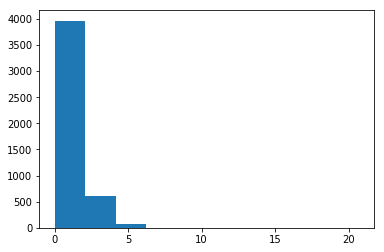

In [106]:
# Visual inspection of one column
import matplotlib.pyplot as plt
plt.hist(df_updated_corr["MgO"])
plt.show()

In [149]:
# Save wrong entries to disk; to be cleaned manually by Sebastian
wrong_entries.to_excel("../_NEEDS_CLEANING/Vistelius_data_to_be_cleaned.xlsx")

In [135]:
# Save correct entries to disk
right_entries.to_excel("../_CLEANED/Vistelius_cleaned_part1.xlsx")

In [109]:
data_updated.loc[4596, :]

SiO2       55.83
TiO2        0.75
Al2O3      18.70
Fe2O3       3.72
FeO      4049.00
MnO        18.00
MgO         2.46
CaO         7.04
Na2O     3012.00
K2O         2.64
P2O5        0.40
l.i.        1.17
oth          NaN
sum       100.50
hs          0.61
Name: 4596, dtype: float64

___

### Combine cleaned database parts

In [136]:
data_cleaned_part1 = pd.read_excel("../_CLEANED/Vistelius_cleaned_part1.xlsx")
data_cleaned_part2 = pd.read_excel("../_CLEANED/Vistelius_cleaned_part2.xlsx")

In [138]:
# Merge manually corrected wrong entries with already correct entries into one dataframe
data_cleaned = pd.concat([data_cleaned_part1, data_cleaned_part2])

In [142]:
data_cleaned = data_cleaned.sort_index()

In [148]:
# Double check to make sure all entries are correct
data_cleaned[np.invert(np.isclose(data_cleaned.iloc[:, 0:13].sum(axis=1), data_cleaned["sum"], atol=0.1))]

,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
2362,70.8,0.1,15.08,0.96,2.31,0.04,0.54,1.93,2.51,4.43,0.09,0.7,NaN,99.94,0.1


In [150]:
# Correct one mistake in entry of 'sum'
data_cleaned.loc[2362, "sum"] = 99.49

In [151]:
# Check again --> no more errors to be expected
data_cleaned[np.invert(np.isclose(data_cleaned.iloc[:, 0:13].sum(axis=1), data_cleaned["sum"], atol=0.1))]

,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs


In [153]:
# Check data types of all columns to make sure they're all numeric (float)
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4659 entries, 1 to 4659
Data columns (total 15 columns):
SiO2     4659 non-null float64
TiO2     4626 non-null float64
Al2O3    4659 non-null float64
Fe2O3    4657 non-null float64
FeO      4659 non-null float64
MnO      4544 non-null float64
MgO      4658 non-null float64
CaO      4659 non-null float64
Na2O     4659 non-null float64
K2O      4659 non-null float64
P2O5     3833 non-null float64
l.i.     4659 non-null float64
oth      874 non-null float64
sum      4659 non-null float64
hs       2240 non-null float64
dtypes: float64(15)
memory usage: 742.4 KB


In [154]:
# Save "final" version of compositional data to disk
data_cleaned.to_excel("../_CLEANED/Vistelius_cleaned.xlsx")

___